In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from torch.utils.data import random_split
import pytorch_lightning as pl
from typing import Dict, List, Union
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.resnet import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
class HakeXarrayDatasets(Dataset):
    def __init__(self, data: Union[List[str], Dict[str, str]],
                 desired_order: List[str] = ["120 kHz", "38 kHz", "18 kHz"]):
        self.desired_order = desired_order

        if isinstance(data, list):
            self.data_files = []  # Store data files in a list
            self.load_from_data_dir_list(data)
        elif isinstance(data, dict):
            self.data_files = {}  # Store key-value pairs (target file, data file)
            self.load_from_target_data_dict(data)
        else:
            raise ValueError("Invalid input type for 'data'. It should be either a list or a dictionary.")

    def load_from_target_data_dict(self, target_data_dir_dict):
        for target_path, data_path in target_data_dir_dict.items():
            target_path = Path(target_path)
            data_path = Path(data_path)

            # Get all .zarr files in the data directory
            data_files = list(data_path.glob('*.zarr'))

            for data_file in tqdm(data_files[:5]):
                self.process_target_path_and_data_file(data_file, target_path)

    def load_from_data_dir_list(self, data_dirs):
        for data_dir in data_dirs:
            data_dir = Path(data_dir)

            # Get all .zarr files in the data directory
            unchecked_data_files = list(data_dir.glob('*.zarr'))

            for data_file in tqdm(unchecked_data_files[:5]):
                # Check if Sv and channel values exist in the data file
                if self.check_data_file(data_file):
                    self.data_files.append(data_file)

    def check_data_file(self, data_file):
        try:
            # Open datasets and check for variables and desired channels
            data_ds = xr.open_dataset(data_file)
            data_channels = data_ds["Sv"].channel.values

            return all(any(partial_name in ch for ch in data_channels) for partial_name in self.desired_order)

        except KeyError as e:
            # Print KeyError and file paths
            print(f"KeyError: {e}, File Paths: {data_file}")
            return False

    def process_target_path_and_data_file(self, data_file, target_dir):
        # Extract filename without considering the path
        data_filename = data_file.name

        # Find a matching target file by filename in the target directory
        target_file = self.find_matching_target(data_filename, target_dir)

        if target_file is not None:
            try:
                # Open datasets and check for variables and desired channels
                data_ds = xr.open_dataset(data_file)
                xr.open_dataset(target_file)

                data_channels = data_ds["Sv"].channel.values

                if all(any(partial_name in ch for ch in data_channels) for partial_name in self.desired_order):
                    # If a list is initialized, store data files in a list
                    if self.data_files is None:
                        self.data_files = [data_file]
                    else:
                        # Store key-value pairs (target file, data file)
                        self.data_files[target_file] = data_file
                else:
                    print(f"Not all desired channels found in data file: {data_file}")
                    print(data_channels)

            except KeyError as e:
                # Print KeyError and file paths
                print(f"KeyError: {e}, File Paths: {data_file}, {target_file}")
                # Skip if "Sv" or "mask" variables do not exist
                pass

    def find_matching_target(self, data_filename, target_dir):
        target_files = list(target_dir.glob('*.zarr'))

        for target_file in target_files:
            if target_file.name == data_filename:
                return target_file

        return None

    def _channel_sort_by_partial_names(self, channel_name):
        for idx, partial_name in enumerate(self.desired_order):
            if partial_name in channel_name:
                return idx
        return len(self.desired_order)

    def __len__(self):
        if self.data_files is not None:
            return len(self.data_files)
        else:
            return 0
        
    def resize_data(self, data, size, mode='nearest'):
        # Resize data to the specified size using trilinear interpolation
        resized_data = F.interpolate(data.unsqueeze(0).unsqueeze(0), size=size, mode=mode)
        return resized_data.squeeze().numpy()

    def __getitem__(self, idx):
        if self.data_files is not None:
            if isinstance(self.data_files, list):
                data_file = self.data_files[idx]
                data_ds = xr.open_dataset(data_file)
                data_channels = data_ds["Sv"].channel.values
                desired_data_channels = [ch for ch in data_channels if any(partial_name in ch for partial_name in self.desired_order)]
                data = data_ds["Sv"].transpose("channel", "depth", "ping_time").sel(channel=desired_data_channels).data

                # Clipping Values
                data[:, :, :2][data[:, :, :2] < -70] = -70
                data[:, :, :][data[:, :, :] < -69] = -69
                data[data > -36] = -36

                # Normalization and Image Creation
                sv_min = np.array([-70, -70, -69]).reshape((3, 1, 1))
                sv_max = -36 
                data[np.isnan(data)] = 0.0  # Set NaN values to 0
                data = torch.tensor(((data - sv_min) / (sv_max - sv_min)) * 255.0, dtype=torch.float32)

                data = self.resize_data(data, (3, 512, 512))

                return data

            elif isinstance(self.data_files, dict):
                target_file = list(self.data_files.keys())[idx]
                data_file = self.data_files[target_file]
                data_ds = xr.open_dataset(data_file)
                data_channels = data_ds["Sv"].channel.values
                desired_data_channels = [ch for ch in data_channels if any(partial_name in ch for partial_name in self.desired_order)]
                data = data_ds["Sv"].transpose("channel", "depth", "ping_time").sel(channel=desired_data_channels).data

                # Clipping Values
                data[:, :, :2][data[:, :, :2] < -70] = -70
                data[:, :, :][data[:, :, :] < -69] = -69
                data[data > -36] = -36

                # Normalization and Image Creation
                sv_min = np.array([-70, -70, -69]).reshape((3, 1, 1))
                sv_max = -36 
                data[np.isnan(data)] = 0.0  # Set NaN values to 0
                data = torch.tensor(((data - sv_min) / (sv_max - sv_min)) * 255.0, dtype=torch.float32)

                data = self.resize_data(data, (3, 512, 512))

                # Mask Processing
                target = xr.open_dataset(target_file)["mask"].transpose("depth", "ping_time").data
                target = torch.tensor(target, dtype=torch.float32)

                # Resize data
                target = self.resize_data(target, (512, 512))

                return data, target
        else:
            raise IndexError("Index out of range. No data files available.")

100%|██████████| 5/5 [00:00<00:00, 152.07it/s]


Dataset Length: 3


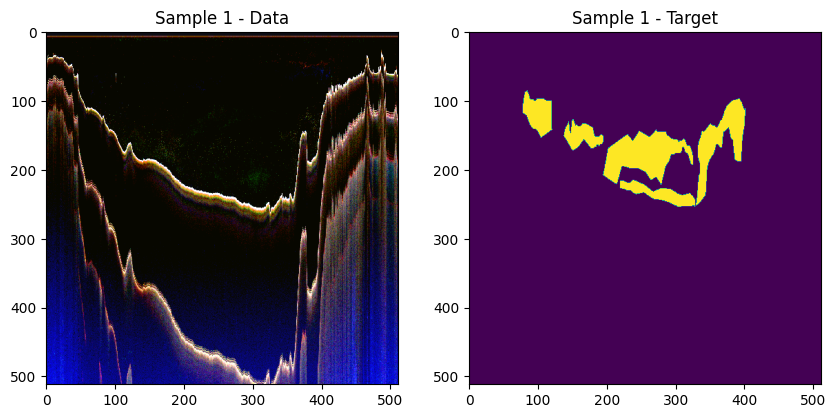

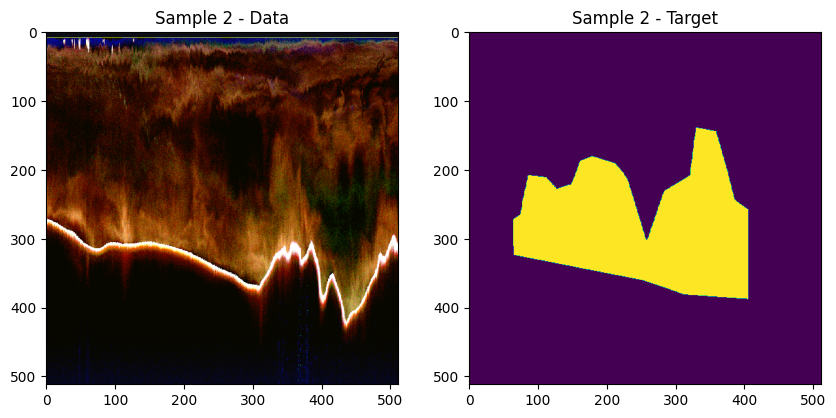

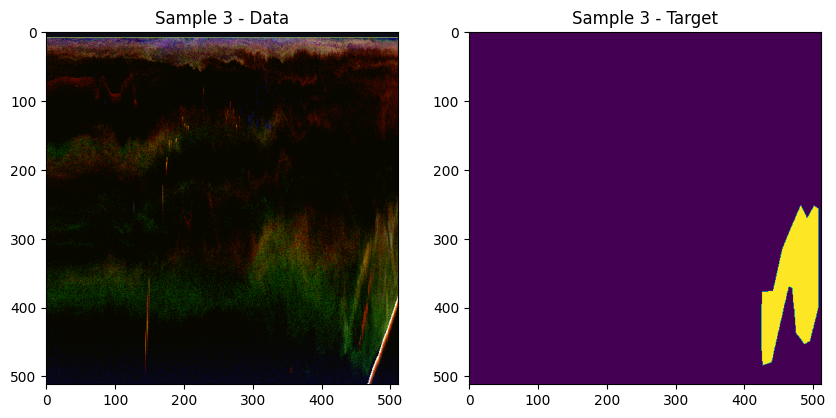

In [262]:
# Example usage dict
data_target_dir_dict = {'/home/exouser/hake_data/Sv_mask/hake/2007': '/home/exouser/hake_data/Sv_regridded/2007',
                    '/home/exouser/hake_data/Sv_mask/hake/2009': '/home/exouser/hake_data/Sv_regridded/2009'}

# Create an instance of HakeXarrayDatasets
hake_dataset = HakeXarrayDatasets(data_target_dir_dict)

# Print the length of the dataset
print("Dataset Length:", len(hake_dataset))

# Loop through the dataset and print some samples
for idx in range(len(hake_dataset)):
    data, target = hake_dataset[idx]

    data = np.transpose(data, (1, 2, 0)).astype(np.uint8)
    target = target.astype(np.uint8)
    
    # Display the images
    plt.figure(figsize=(10, 5))
    
    # Display the data image
    plt.subplot(1, 2, 1)
    plt.imshow(data)
    plt.title(f'Sample {idx + 1} - Data')
    
    # Display the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target)
    plt.title(f'Sample {idx + 1} - Target')
    
    plt.show()

100%|██████████| 5/5 [00:00<00:00, 233.23it/s]


Dataset Length: 10


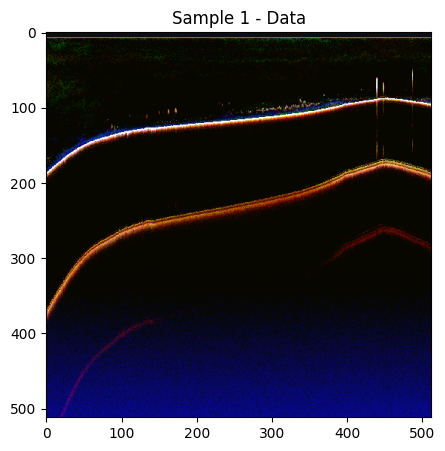

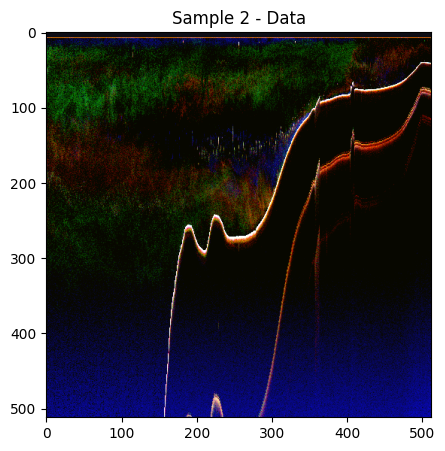

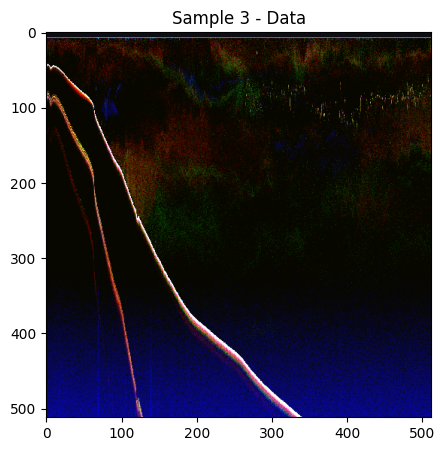

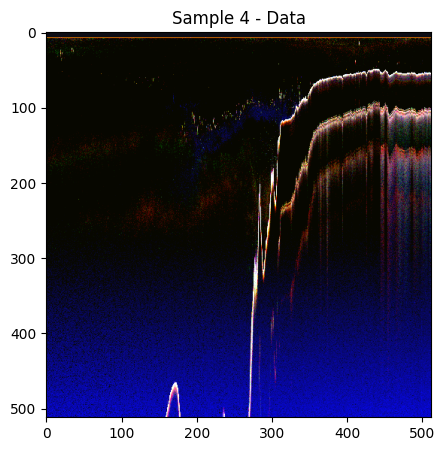

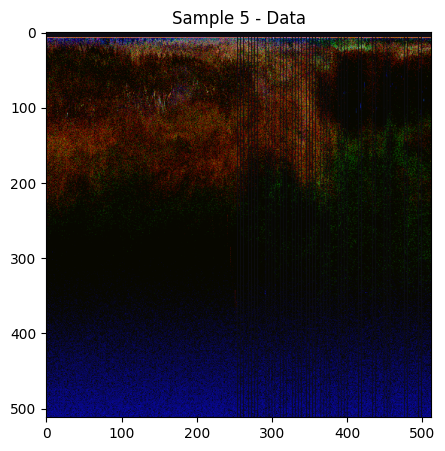

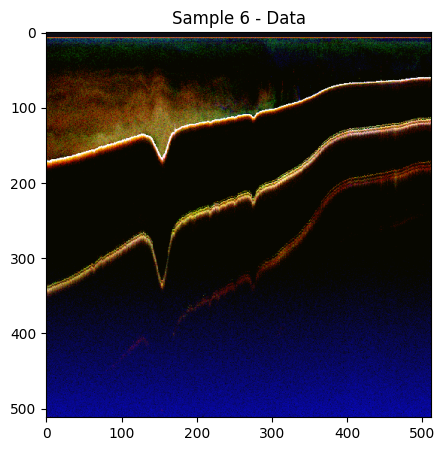

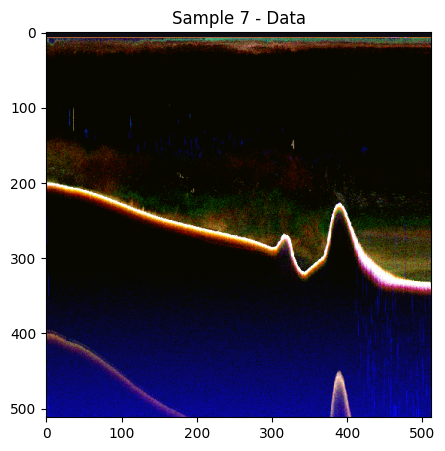

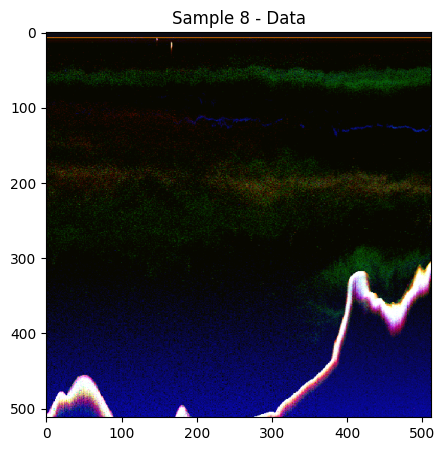

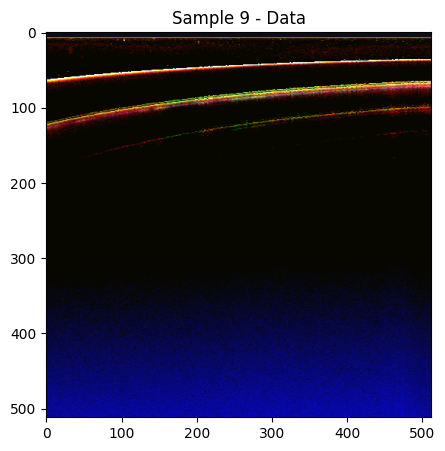

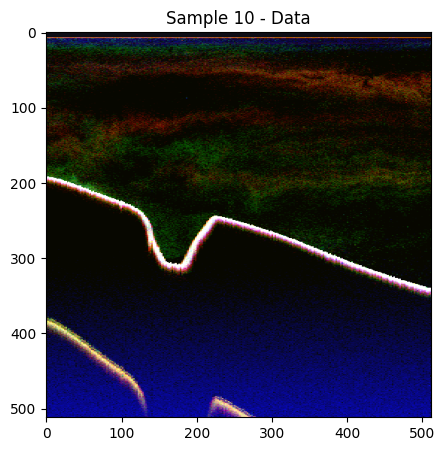

In [263]:
# Example usage list
data_dir = ['/home/exouser/hake_data/Sv_regridded/2017', '/home/exouser/hake_data/Sv_regridded/2019']

# Create an instance of HakeXarrayDatasets
hake_dataset = HakeXarrayDatasets(data_dir)

# Print the length of the dataset
print("Dataset Length:", len(hake_dataset))

# Loop through the dataset and print some samples
for idx in range(len(hake_dataset)):
    data = hake_dataset[idx]
    data = np.transpose(data, (1, 2, 0)).astype(np.uint8)

    # Display the images
    plt.figure(figsize=(5, 5))
    
    # Display the data image
    plt.subplot(1, 1, 1)
    plt.imshow(data)
    plt.title(f'Sample {idx + 1} - Data')
    
    plt.show()

In [3]:
class HakeDataModule(pl.LightningDataModule):
    def __init__(self, training_target_data_dir_dict: dict, testing_target_data_dir_dict: dict,
                 pred_dir: dict, batch_size=32, num_workers=4, validation_split=0.1):
        super(HakeDataModule, self).__init__()
        self.training_target_data_dir_dict = training_target_data_dir_dict
        self.testing_target_data_dir_dict = testing_target_data_dir_dict
        self.pred_dir = pred_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.validation_split = validation_split

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            full_train_dataset = HakeXarrayDatasets(self.training_target_data_dir_dict)
            train_size = int((1 - self.validation_split) * len(full_train_dataset))
            val_size = len(full_train_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(full_train_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        test_dataset = HakeXarrayDatasets(self.testing_target_data_dir_dict)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def pred_dataloader(self):
        pred_dataset = HakeXarrayDatasets(self.pred_dir)
        return DataLoader(pred_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
training_target_data_dir_dict = {'/home/exouser/hake_data/Sv_mask/hake/2007': '/home/exouser/hake_data/Sv_regridded/2007',
                    '/home/exouser/hake_data/Sv_mask/hake/2009': '/home/exouser/hake_data/Sv_regridded/2009'}
testing_target_data_dir_dict = {'/home/exouser/hake_data/Sv_mask/hake/20011': '/home/exouser/hake_data/Sv_regridded/20011',
                    '/home/exouser/hake_data/Sv_mask/hake/2013': '/home/exouser/hake_data/Sv_regridded/2013'}
pred_dir = ['/home/exouser/hake_data/Sv_regridded/2017', '/home/exouser/hake_data/Sv_regridded/2019']

data_module = HakeDataModule(
    training_target_data_dir_dict=training_target_data_dir_dict,
    testing_target_data_dir_dict=testing_target_data_dir_dict,
    pred_dir=pred_dir,
    batch_size=32,
    num_workers=4,
    validation_split=0.1
)

data_module.setup()

100%|██████████| 5/5 [00:00<00:00, 290.81it/s]


In [170]:
# Train DataLoader
train_dataloader = data_module.train_dataloader()
for batch_idx, batch in enumerate(train_dataloader):
    print(f"Training Batch {batch_idx + 1}:", batch)

# Validation DataLoader
val_dataloader = data_module.val_dataloader()
for batch_idx, batch in enumerate(val_dataloader):
    print(f"Validation Batch {batch_idx + 1}:", batch)

# Test DataLoader
test_dataloader = data_module.test_dataloader()
for batch_idx, batch in enumerate(test_dataloader):
    print(f"Test Batch {batch_idx + 1}:", batch)

# Prediction DataLoader
pred_dataloader = data_module.pred_dataloader()
for batch_idx, batch in enumerate(pred_dataloader):
    print(f"Prediction Batch {batch_idx + 1}:", batch)

Training Batch 1: [tensor([[[[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         ...,

         [[ 7,  7, 35],
          [ 7,  7, 46],
          [ 7,  7, 59],
          ...,
          [15,  7, 44],
          [13, 48, 67],
          [60,  7, 15]],

         [[ 7,  7,  0],
          [ 7,  7, 30],
          [ 7,  7, 40],
          ...,
          [ 7,  7,  7],
          [11, 15, 50],
          [64, 42, 51]],

         [[ 7,  7, 89],
          [ 7,  7,  0],
          [ 7,  7, 16],
          ...,
          [26, 38, 26],
          [ 7,  7, 45],
          [67, 71, 14]]],


0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 248.34it/s]


Test Batch 1: [tensor([[[[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         ...,

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [ 7,  7,  0],
          [ 7, 15,  0],
          [ 7,  7,  0]],

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0]],

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0]]],


  

100%|██████████| 5/5 [00:00<00:00, 223.13it/s]


Prediction Batch 1: tensor([[[[ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21],
          ...,
          [ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21]],

         [[ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21],
          ...,
          [ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21]],

         [[ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21],
          ...,
          [ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21]],

         ...,

         [[  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0],
          ...,
          [  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0]],

         [[  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0],
          ...,
          [  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0]],

         [[  7,   7,   0],
          [  7,   7,   0],
          [  7, 

In [5]:
class DeepLabV3(pl.LightningModule):
    def __init__(self, num_cls=1, output_stride=8):
        super(DeepLabV3, self).__init__()
        self.num_cls = num_cls
        self.feature = None
        self.classifier = None
        self.output_stride = output_stride

        # Set criterion (MSE loss)
        self.criterion = nn.MSELoss()

        # Model setup and weights initialization
        self.setup_net()

    def setup_net(self):
        self.feature = IntermediateLayerGetter(resnet50(pretrained=True),
                                               return_layers = {'layer4': 'out'}) 
        self.classifier = DeepLabHead(2048, self.num_cls)

        for m in self.feature.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.momentum = 0.01

    def forward(self, data):
        input_shape = data.shape[-2:]
        features = self.feature(data)
        outputs = self.classifier(features['out'])
        outputs = F.interpolate(outputs, size=input_shape, mode='bilinear', align_corners=False)
        return outputs.squeeze(1)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)

        # Log training loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)

        # Log validation loss
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [6]:
model = DeepLabV3(num_cls=1)

In [7]:
# Instantiate the Lightning Trainer with TensorBoardLogger
logger = TensorBoardLogger("logs", name="my_experiment")
trainer = pl.Trainer(
    max_epochs=2,
    logger=logger,
)

# Train the model using the Trainer
trainer.fit(model, data_module.train_dataloader(), data_module.val_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: logs/my_experiment

  | Name       | Type                    | Params
-------------------------------------------------------
0 | criterion  | MSELoss                 | 0     
1 | feature    | IntermediateLayerGetter | 23.5 M
2 | classifier | DeepLabHead             | 16.1 M
-------------------------------------------------------
39.6 M    Trainable params
0         Non-trainable params
39.6 M    Total params
158.535   Total estimated model params size (MB)


/home/exouser/miniforge3/envs/hake_ml_poc/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 1/1 [00:26<00:00,  0.04it/s, v_num=0, train_loss_step=0.703, val_loss_step=17.00, val_loss_epoch=17.00, train_loss_epoch=0.703]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:27<00:00,  0.04it/s, v_num=0, train_loss_step=0.703, val_loss_step=17.00, val_loss_epoch=17.00, train_loss_epoch=0.703]


In [8]:
# Access training statistics
training_stats = trainer.callback_metrics

# Print or analyze the training statistics
print(training_stats)

{'train_loss': tensor(0.7035), 'train_loss_step': tensor(0.7035), 'val_loss': tensor(17.0409), 'val_loss_epoch': tensor(17.0409), 'train_loss_epoch': tensor(0.7035)}
